In [1]:
from sklearn.model_selection import train_test_split
from googleapiclient.discovery import build
import io, os
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth
import os
import pandas as pd
from fastai.text import *

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


###Loading model

In [2]:
auth.authenticate_user()

drive_service = build('drive', 'v3')
results = drive_service.files().list(
        q="name = 'kaggle.json'", fields="files(id)").execute()
kaggle_api_key = results.get('files', [])

filename = "/content/.kaggle/kaggle.json"
os.makedirs(os.path.dirname(filename), exist_ok=True)

request = drive_service.files().get_media(fileId=kaggle_api_key[0]['id'])
fh = io.FileIO(filename, 'wb')
downloader = MediaIoBaseDownload(fh, request)
done = False
while done is False:
    status, done = downloader.next_chunk()
    print("Download %d%%." % int(status.progress() * 100))
os.chmod(filename, 600)

Download 100%.


In [3]:
!mv .kaggle /root/

In [4]:
!kaggle datasets download -d shivamkushwaha/bbc-full-text-document-classification

 89% 5.00M/5.59M [00:00<00:00, 38.4MB/s]
100% 5.59M/5.59M [00:00<00:00, 35.7MB/s]


In [5]:
!ls

adc.json  bbc-full-text-document-classification.zip  sample_data


In [6]:
!unzip bbc-full-text-document-classification.zip

Archive:  bbc-full-text-document-classification.zip
  inflating: bbc-fulltext (document classification)/bbc/README.TXT  
  inflating: bbc-fulltext (document classification)/bbc/business/001.txt  
  inflating: bbc-fulltext (document classification)/bbc/business/002.txt  
  inflating: bbc-fulltext (document classification)/bbc/business/003.txt  
  inflating: bbc-fulltext (document classification)/bbc/business/004.txt  
  inflating: bbc-fulltext (document classification)/bbc/business/005.txt  
  inflating: bbc-fulltext (document classification)/bbc/business/006.txt  
  inflating: bbc-fulltext (document classification)/bbc/business/007.txt  
  inflating: bbc-fulltext (document classification)/bbc/business/008.txt  
  inflating: bbc-fulltext (document classification)/bbc/business/009.txt  
  inflating: bbc-fulltext (document classification)/bbc/business/010.txt  
  inflating: bbc-fulltext (document classification)/bbc/business/011.txt  
  inflating: bbc-fulltext (document classification)/bb

In [7]:
!ls

 adc.json  'bbc-fulltext (document classification)'     sample_data
 bbc	    bbc-full-text-document-classification.zip


In [8]:
!cd bbc
!ls

 adc.json  'bbc-fulltext (document classification)'     sample_data
 bbc	    bbc-full-text-document-classification.zip


In [39]:
df = pd.DataFrame(columns=('text', 'target'))

def add_data(dir_, target_,df):
  for dir, subdirs, files in os.walk(dir_):
    for f in files:
      filepath = os.path.join(dir, f)
      try:
        with open(filepath,) as file:
          text = []
          for line in  file:
            text.append(line) 
          df = df.append({'text':text, 'target' : target_},ignore_index=True)
      except UnicodeDecodeError:
        print("Break file: ", filepath)
  return df

list_dirs_targets = [('bbc/entertainment',0),('bbc/tech',1),('bbc/politics',2),('bbc/business',3),('bbc/sport',4)]
for dir, target in list_dirs_targets:
  print(dir)
  df = add_data(dir, target, df)  

print(df.head())

bbc/entertainment
bbc/tech
bbc/politics
bbc/business
bbc/sport
Break file:  bbc/sport/199.txt
                                                text target
0  [Wine comedy up for six film gongs\n, \n, Side...      0
1  [Brookside actress Keaveney dies\n, \n, Actres...      0
2  [Baby becomes new Oscar favourite\n, \n, Clint...      0
3  [Briton wins short film Oscar\n, \n, Three of ...      0
4  [DVD review: I, Robot\n, \n, Only one man reco...      0


###Language model

In [27]:
train, test = train_test_split(df, test_size=0.3)

In [29]:
bs = 64
data_lm = (TextList.from_df(train, cols='text')
                .split_by_rand_pct(0.1) #seed=42
                .label_for_lm()
                .databunch(bs=bs))
data_lm.show_batch()

idx,text
0,"250 ( £ xxunk ) and the first million sold will come with xxmaj spider - xxmaj man 2 on xxup umd , the disc format for the machine . xxmaj sony has billed the machine as the xxmaj walkman of the 21st xxmaj century and has sold more than 800,000 units in xxmaj japan . xxmaj the console ( 12 cm by 7.4 cm ) will play games ,"
1,"hung parliament with no party in overall control . xxmaj sir xxmaj edward had gone to the country for a fresh xxunk amid the spiralling economic crisis , a xxunk ' strike and the subsequent three - day week . xxmaj labour emerged with the most seats - but its xxunk mps were 17 short of the number xxmaj mr xxmaj wilson needed to form a majority . \n"
2,""" ] xxbos [ ' xxup ibm xxunk 500 software patents \n ' , ' \n ' , ' xxmaj computer giant xxup ibm says 500 of its software patents will be released into the open development community . \n ' , ' \n ' , ' xxmaj the move means developers will be able to use the technologies without paying for a licence from the"
3,""" xxmaj ireland \ 's economic \ ' miracle \ ' is enjoying a second wind , with 5 % growth forecast for 2005 and 2006 . xxmaj the economy cooled xxunk between 2001 and 2003 after enjoying xxunk growth of more than 10 % in 2000 . xxmaj however , it has bounced back strongly with growth of just under 5 % expected in 2004 . \n '"
4,"games ceremony , the xxmaj golden xxmaj joystick awards . \n ' , ' \n ' , ' xxmaj it was the only title to win twice , winning xxmaj ultimate xxmaj game of the year and best xxup pc game at the awards , presented by xxmaj little xxmaj britain star xxmaj matt xxmaj lucas . xxmaj the much - anticipated sci - fi horror xxmaj doom"


epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 4.79E-02
Min loss divided by 10: 1.00E-02


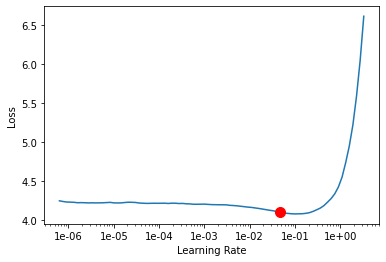

In [34]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)
learn.lr_find()
learn.recorder.plot(suggestion = True)

In [51]:
learn.fit_one_cycle(1, 4.79E-02, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,2.734064,3.561502,0.380357,00:19


In [52]:
learn.unfreeze()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.32E-06
Min loss divided by 10: 1.20E-04


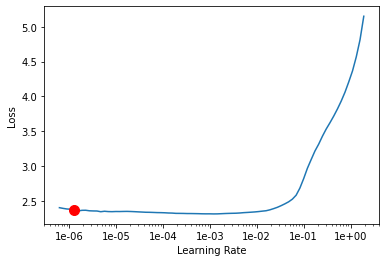

In [56]:
learn.lr_find()
learn.recorder.plot(suggestion = True)

In [74]:
learn.fit_one_cycle(1, 1.32E-06, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,2.239036,3.501863,0.388722,00:24


In [75]:
learn.save('fine_tuned')

In [76]:
learn.save_encoder('fine_tuned_enc')

###Classifier

In [77]:
data_clas = (TextList.from_df(train, cols='text', vocab=data_lm.vocab)
                .split_by_rand_pct(0.2, seed = 42)
                .label_from_df(cols=1)
                .databunch(bs=bs))а

In [79]:
data_clas.save('data_clas1.pk1')

In [80]:
data_clas.show_batch()

text,target
"xxbos [ "" xxmaj terror powers expose ' tyranny ' \n "" , ' \n ' , "" xxmaj the xxmaj lord xxmaj chancellor has defended government plans to introduce control orders to keep foreign and xxmaj british terrorist suspects under house arrest , where there is n't enough evidence to put them on trial . \n "" , ' \n ' , ' xxmaj lord",2
"xxbos [ ' xxmaj scissor xxmaj sisters triumph at xxmaj brits \n ' , ' \n ' , ' xxup us band xxmaj scissor xxmaj sisters led the winners at the xxup uk music industry \ 's xxmaj brit xxmaj awards , walking off with three prizes . xxmaj the xxunk act scored a hat - trick in the international categories , winning the best group , best",0
"xxbos [ ' xxmaj losing yourself in online gaming \n ' , ' \n ' , ' xxmaj online role playing games are time - consuming , but xxunk flights from reality . xxmaj but are some people taking their fantasy lives too seriously ? \n ' , ' \n ' , ' xxmaj when video game xxmaj world of xxmaj warcraft hit the shops in",1
"xxbos [ ' xxmaj roundabout continues nostalgia trip \n ' , ' \n ' , "" xxmaj the new big - screen version of xxmaj the xxmaj magic xxmaj roundabout , released in the xxup uk on xxmaj friday , is the latest attempt to turn children 's television into box - office gold . \n "" , ' \n ' , "" xxmaj recent years",0
"xxbos [ ' xxmaj all xxmaj black magic : xxmaj new xxmaj zealand rugby \n ' , ' \n ' , ' xxmaj playing colours : \n ' , ' \n ' , ' xxmaj all black \n ' , ' \n ' , ' xxmaj the xxmaj haka and more ! \n ' , ' \n ' , ' xxmaj the",4


In [82]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)
learn.load_encoder('fine_tuned_enc');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.63E-03
Min loss divided by 10: 1.10E-01


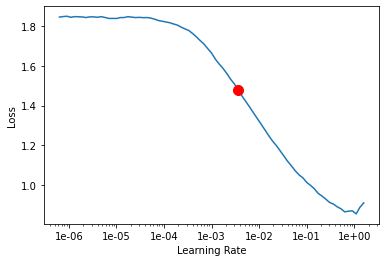

In [83]:
learn.lr_find()
learn.recorder.plot(suggestion = True)

In [87]:
learn.fit_one_cycle(1, 3.63E-03, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.087688,0.149635,0.967846,00:13


In [88]:
learn.freeze_to(-2)

In [89]:
learn.save('first')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07
Min loss divided by 10: 3.63E-06


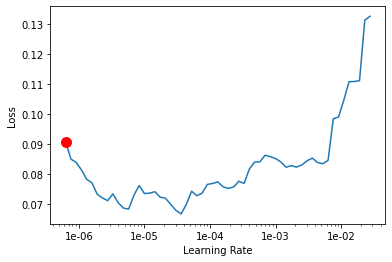

In [90]:
learn.lr_find()
learn.recorder.plot(suggestion = True)

In [92]:
learn.fit_one_cycle(1, 6.31E-07, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.085741,0.149604,0.967846,00:14


In [93]:
learn.save('second')

In [95]:
learn.freeze_to(-3)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.29E-06
Min loss divided by 10: 6.31E-04


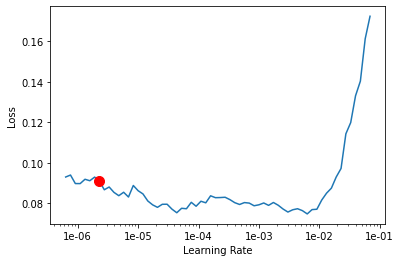

In [96]:
learn.lr_find()
learn.recorder.plot(suggestion = True)

In [97]:
learn.fit_one_cycle(1, 2.29E-06, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.073696,0.148301,0.971061,00:19


In [98]:
learn.save('third')

In [99]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 7.59E-07
Min loss divided by 10: 1.91E-07


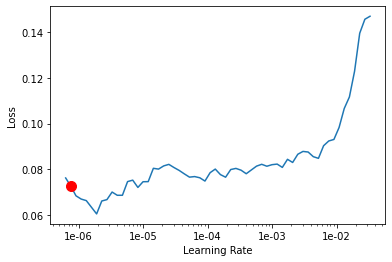

In [100]:
learn.lr_find()
learn.recorder.plot(suggestion = True)

In [102]:
learn.fit_one_cycle(5, 7.59E-07, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.101137,0.149941,0.974277,00:22
1,0.087847,0.149500,0.967846,00:25
2,0.081106,0.145181,0.971061,00:25
3,0.076138,0.146827,0.974277,00:24
4,0.077414,0.147172,0.971061,00:24


In [104]:
learn.save('whole_model')

###Evaluation

In [105]:
learn.predict('A sportsman ran fast.')

(Category tensor(4),
 tensor(4),
 tensor([9.8330e-02, 6.4085e-02, 4.5447e-05, 9.3824e-06, 8.3753e-01]))

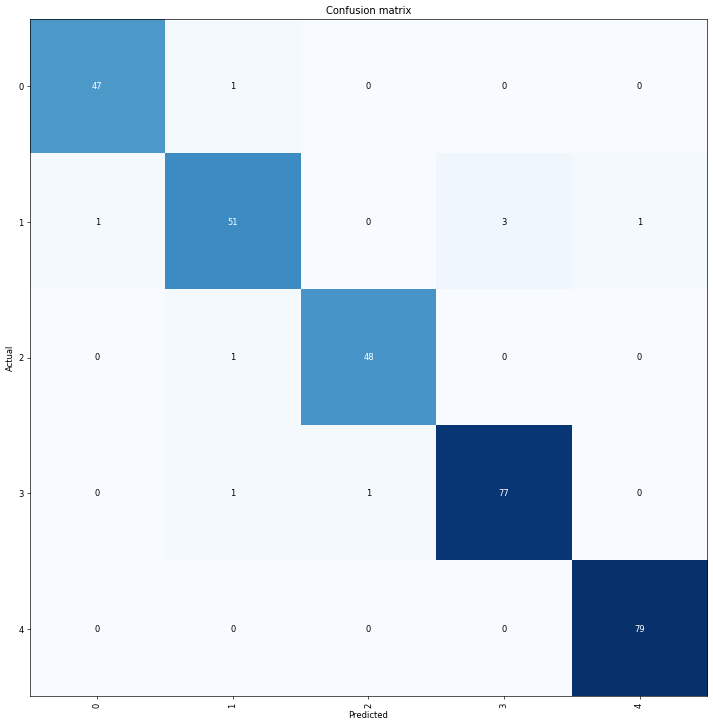

In [108]:
interp = ClassificationInterpretation.from_learner(learn)
losses, idxs = interp.top_losses()
interp.plot_confusion_matrix(figsize = (12,12),dpi = 60)

In [110]:
interp.most_confused(min_val=2)

[(1, 3, 3)]

In [111]:
tech business